<a target="_blank" href="https://colab.research.google.com/github/lm2612/Tutorials/blob/main/4_computervision/4-ComputerVision_Classification.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Convolutional Neural Network Classifier

Today we will build convolutional neural network to classify pets using the [Oxford pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) which consists of thousands of photos of cats and dogs.

Import packages and load the dataset. We have chosen this dataset as it was one of torchvision's built-in datasets available from [https://pytorch.org/vision/main/datasets.html](https://pytorch.org/vision/main/datasets.html)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, ToPILImage, Compose, CenterCrop, Resize
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

# Transforms
img_to_tensor = ToTensor()
tensor_to_img = ToPILImage()
crop = CenterCrop(360)        # crop all images to same size (360 x 360)
resize = Resize(128)          # resize so images are smaller / computationally cheaper

# the Oxford pet dataset is labelled by 37 breeds of cats and dogs, but we
# will use the dataset to predict species cat (0) or dog (1)
# manually define transform to convert breed id (1-37) to species id (0/1)
cat_breed_ids = [0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33]

def breed2species(breedid):
    if breedid in cat_breed_ids:
        return 0
    else:
        return 1

data = datasets.OxfordIIITPet(
    root="./",
    download=True,
    target_types = "category",
    transform=Compose([img_to_tensor, crop, resize]),
    target_transform=breed2species
)

100%|██████████| 792M/792M [00:03<00:00, 208MB/s]
100%|██████████| 19.2M/19.2M [00:00<00:00, 114MB/s] 


## Set up
First, use `torch.utils.data.random_split` to split the data into 80% training, 10% training and 10% validation.

In [19]:
data

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: ./
    StandardTransform
Transform: Compose(
               ToTensor()
               CenterCrop(size=(360, 360))
               Resize(size=128, interpolation=bilinear, max_size=None, antialias=True)
           )
Target transform: <function breed2species at 0x7cf955aef9c0>

In [2]:
training_data, validation_data, test_data = torch.utils.data.random_split(data, lengths=[0.8, 0.1, 0.1])

Check the shape of the images and what they look like: Use the transform `tensor_to_img()` to quickly plot images.

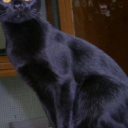

In [6]:
X, y = training_data[0]
tensor_to_img(X)


In [7]:
X.shape

torch.Size([3, 128, 128])

## Create our dataloaders
Set up a dataloader for the training data with a batch size of 128 and a validation data with a batch size of 64.

In [8]:
dataloader = torch.utils.data.DataLoader(training_data,
                                         shuffle=True,
                                         batch_size=128)
dataloader_validation = torch.utils.data.DataLoader(validation_data,
                                         shuffle=True,
                                         batch_size=64)

In [9]:
len(training_data), len(validation_data)

(2944, 368)

0


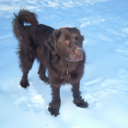

In [87]:
# Get a test batch ready for testing the network layers
X_batch, y_batch = next(iter(dataloader))

# Check the shapes of X_batch, y_batch
print(y)
tensor_to_img(X_batch[0])


## Test network layers
We will create a convolutional network with 3 layers. First, explore what the convolutions are doing.

Here is our first convolutional layer, that includes our convolution, RELU, BatchNorm and Pooling. Read the docs on [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and consider the choices for the arguments. `in_channels`, `out_channels`, and `kernel_size` are always needed, but you can also define `stride` and `padding`. Try some different choices and compare what the output shape is like.

In [56]:
conv_layer_1 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels=3,
                      out_channels=3,
                      kernel_size=3,
                      padding=0),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(3),
      torch.nn.MaxPool2d(2))

Test the first convolutional layer on X_batch. What shape is it? Plot it using `tensor_to_img()`.

In [63]:
# Check shape of X_batch before and after applying conv_layer_1. Remember shape=(BATCH, CHANNELS, WIDTH, HEIGHT)
X_batch.shape



torch.Size([128, 3, 128, 128])

torch.Size([128, 3, 63, 63])


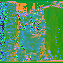

In [64]:
# Plot
X_test_conv = conv_layer_1(X_batch)  # (BATCH, CHANNELS, WIDTH, HEIGHT)
print(X_test_conv.shape)
tensor_to_img(X_test_conv[0])

Notice the size of our tensor has changed: its smaller because of the convolution and pooling. We can see some features from the convolution, that highlight regions of the image where the gradient is quickly changing, which shows us outlines of objects in the image. For the second convolutional layer, we will use the same structure.

In [74]:
conv_layer_2 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels = 3,
                      out_channels = 3,
                      kernel_size = 3,
                      padding=0),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(num_features = 3),
      torch.nn.MaxPool2d(kernel_size = 2))

Test this layer on the output of your previous layer. What shape is it?

In [76]:
X_test_conv = conv_layer_2(X_test_conv)  # (BATCH, CHANNELS, WIDTH, HEIGHT)
print(X_test_conv.shape)
tensor_to_img(X_test_conv[0])


torch.Size([128, 3, 30, 30])


In [61]:
conv_layer_3 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels = 3,
                      out_channels = 3,
                      kernel_size = 3,
                      padding=0),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(num_features = 3),
      torch.nn.MaxPool2d(kernel_size = 2))

Again, test this layer on the output of your previous layer. What shape is it?

In [80]:
X_test_conv = conv_layer_3(X_test_conv)  # (BATCH, CHANNELS, WIDTH, HEIGHT)
print(X_test_conv.shape)
tensor_to_img(X_test_conv[0])

torch.Size([128, 3, 14, 14])


Lastly, we will pass our tensor through a fully connected linear layer to get our output. Use the shape of the previous layer to deduce the number of features going into the linear layer. The size should be `NUM_CHANNELS * NUM_WIDTH * NUM_HEIGHT`.

In [78]:
classifier = torch.nn.Sequential(
      torch.nn.Flatten(),
      torch.nn.Linear(in_features= 3*14*14   ,
                      out_features=1),
      torch.nn.Sigmoid())

In [81]:
classifier(X_test_conv).shape

torch.Size([128, 1])

## Create model
Create a convolutional neural network classifier. As before, it needs to be a `torch.nn.Module` and have the method `forward`. Use the conv layers we have created above, but put them into the class below. Set up the forward module

In [91]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Create CNN in layers
        self.conv_layer_1 = torch.nn.Sequential(
          torch.nn.Conv2d(in_channels=3,
                          out_channels=3,
                          kernel_size=3,
                          padding=0),
          torch.nn.ReLU(),
          torch.nn.BatchNorm2d(num_features = 3),
          torch.nn.MaxPool2d(kernel_size = 2))

        self.conv_layer_2 = torch.nn.Sequential(
          torch.nn.Conv2d(in_channels = 3,
                          out_channels = 3,
                          kernel_size = 3,
                          padding=0),
          torch.nn.ReLU(),
          torch.nn.BatchNorm2d(num_features = 3),
          torch.nn.MaxPool2d(kernel_size = 2))

        self.conv_layer_3 = torch.nn.Sequential(
          torch.nn.Conv2d(in_channels = 3,
                          out_channels = 3,
                          kernel_size = 3,
                          padding=0),
          torch.nn.ReLU(),
          torch.nn.BatchNorm2d(num_features = 3),
          torch.nn.MaxPool2d(kernel_size = 2))

        self.classifier = torch.nn.Sequential(
          torch.nn.Flatten(),
          torch.nn.Linear(in_features=3*14*14,
                          out_features=1),
          torch.nn.Sigmoid()
        )


    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.classifier(x)
        return x


Create an instance of ConvNet and test it on your first batch,

In [93]:
# Create an instance of ConvNet
my_network = ConvNet()
# Apply to first batch
pred_batch = my_network(X_batch)
print(pred_batch.shape)

torch.Size([128, 1])


## Set up loss function and optimiser
Decide on a suitable loss function for a classifier.

We will use Binary Cross Entropy (BCE). Test your loss function with the output of your network.

In [96]:
loss_function = torch.nn.BCELoss()
loss = loss_function(pred_batch.squeeze(), y_batch.float())
loss

tensor(0.6934, grad_fn=<BinaryCrossEntropyBackward0>)

And we also need to set up our optimiser and provide our network parameters. Use the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimiser.

In [99]:
num_params = sum(sum(p.size()) for p in my_network.parameters())
num_params

optimiser = torch.optim.Adam(params = my_network.parameters())

## Training loop
Start the training loop - it will look similar to our training loop from this morning. You can expect it to take several minutes to run - that's why its always sensible to check you can run a smaller version of it first with a subset of the data.

In [100]:
training_losses = []
validation_losses = []
num_epochs = 10

for epoch in range(num_epochs):
    my_network.train()
    training_loss = 0
    for X_batch, y_batch in dataloader:
        optimiser.zero_grad()
        pred_batch = my_network(X_batch)
        loss = loss_function(pred_batch.squeeze(), y_batch.float())
        loss.backward()

        # Update optimiser
        optimiser.step()

        # Add loss to training_loss
        training_loss += loss.item()

    # Add MSE losses to our list for plotting
    training_loss = training_loss / len(dataloader)
    training_losses.append(training_loss)

    # validation
    my_network.eval()
    validation_loss = 0
    for X_batch, y_batch in dataloader_validation:
        pred_batch = my_network(X_batch)
        loss = loss_function(pred_batch.squeeze(), y_batch.float())
        # Add loss to validation_loss
        validation_loss += loss.item()


    # Add MSE losses to our list for plotting
    validation_loss = validation_loss / len(dataloader_validation)
    validation_losses.append(validation_loss)

    # After every epoch print mean losses
    if epoch%1 ==0:
        print(f"After epoch {epoch}: Training loss={training_loss:.2f}, validation loss={validation_loss:.2f}")


After epoch 0: Training loss=0.65, validation loss=0.76
After epoch 1: Training loss=0.59, validation loss=0.76
After epoch 2: Training loss=0.57, validation loss=0.63
After epoch 3: Training loss=0.55, validation loss=0.60
After epoch 4: Training loss=0.54, validation loss=0.60
After epoch 5: Training loss=0.53, validation loss=0.60
After epoch 6: Training loss=0.51, validation loss=0.58
After epoch 7: Training loss=0.51, validation loss=0.59
After epoch 8: Training loss=0.50, validation loss=0.63
After epoch 9: Training loss=0.49, validation loss=0.59


In [ ]:
training_losses, validation_losses

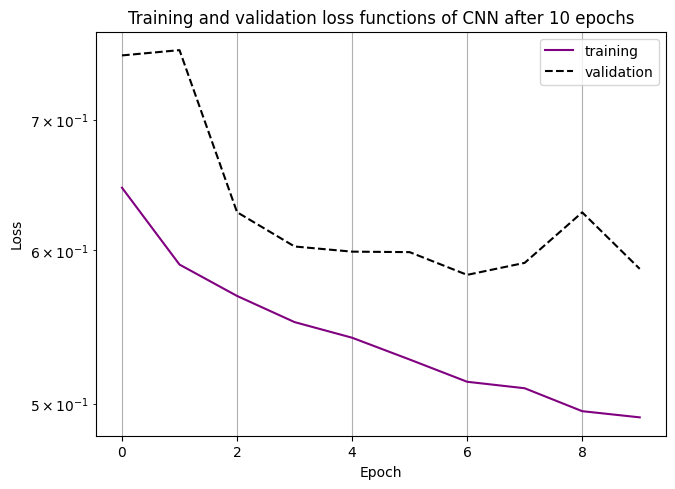

In [104]:
## Plot the training and validation losses on a logscale.
fig, ax = plt.subplots(1, 1)
plt.plot(training_losses, label="training", color = 'purple')
plt.plot(validation_losses,  label="validation", color = 'black', linestyle = '--')
plt.legend()
plt.title('Training and validation loss functions of CNN after 10 epochs')
plt.tight_layout()
plt.ylabel('Loss')
plt.xlabel('Epoch')
ax.set_yscale('log')
plt.grid()
plt.show()


## Results

Write a function to convert the continuous output to zero or one so you can check if the prediction is correct.

In [105]:
def cont_to_binary(pred_batch):
  return torch.where(pred_batch > 0.5, 1.0, 0.0)

def label(y):
  if y < 0.5:
    return "cat"
  elif y > 0.5:
    return "dog"

Plot a few images from the validation dataset and set the title of each image to show if the network predicted "dog" or "cat"

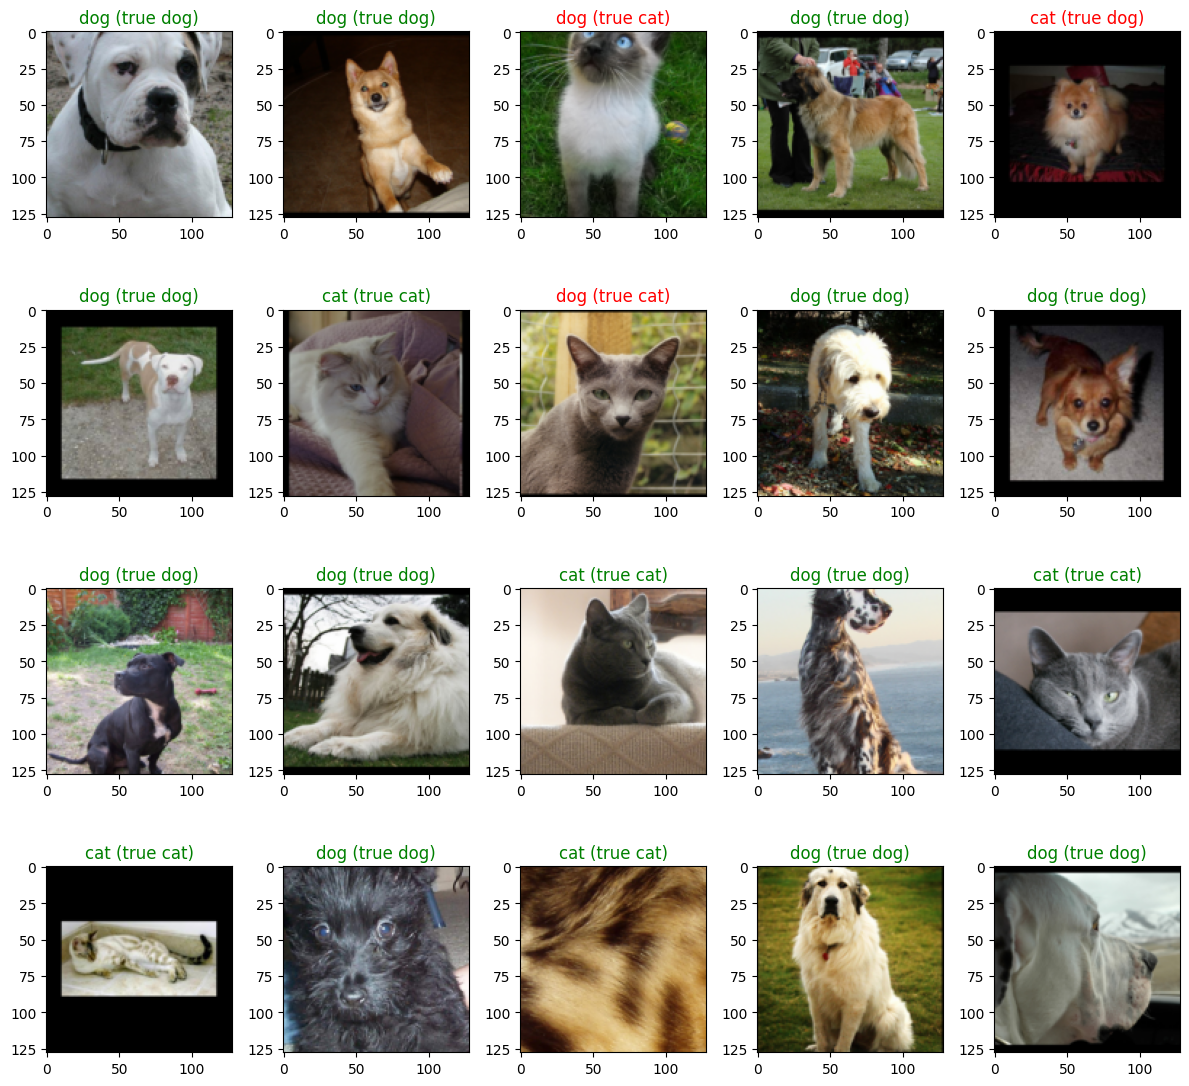

In [113]:
X_batch, y_batch = next(iter(dataloader_validation))
pred_batch = my_network(X_batch)
fig, axs = plt.subplots(4, 5, figsize=(12, 12))
axs = axs.flatten()

for i in range(20):
    y_label = label(y_batch[i])
    pred_label = label(pred_batch[i])
    axs[i].imshow(tensor_to_img(X_batch[i]))
    axs[i].set_title(f"{pred_label} (true {y_label})",
                     color="green" if pred_label is y_label else "red")
    plt.tight_layout()

Congratulations! You've built your own cat/dog classifier. Now try and improve upon it with more data, a deeper or wider network, or with data augmentation. You could also try and predict the breed.

### Check convolutional layers

We discussed in class that convolutions act to either highlight or blur gradients in images, which help identify the shapes and edges of different objects. In general, the first few layers identify basic features within images and deeper layers identify more complex features (they also become more abstract and difficult to interpret!). We can try to investigate what our neural network has learned by looking at what each convolutional layer does after training. What are the convolutional layers doing after training?


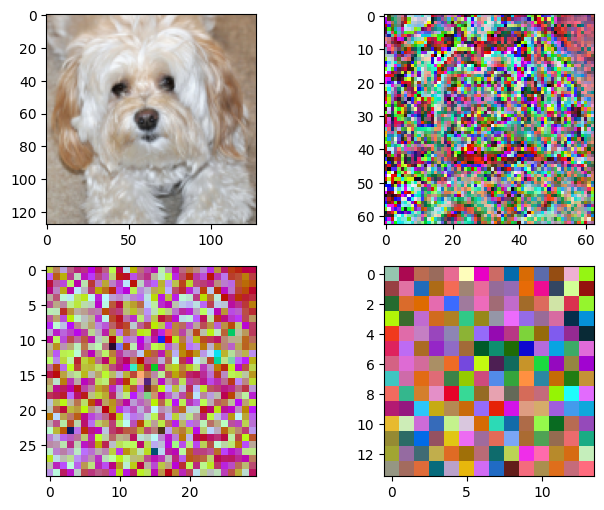

In [114]:
X_batch, y_batch = next(iter(dataloader_validation))

fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()
axs[0].imshow(tensor_to_img(X_batch[0]))

# Layer 1:
X_conv = my_network.conv_layer_1(X_batch)
# Plot on axs[1]
axs[1].imshow(tensor_to_img(X_conv[0]))

# Layer 2:
X_conv = my_network.conv_layer_2(X_conv)
# Plot on axs[2]
axs[2].imshow(tensor_to_img(X_conv[0]))

# Layer 3
X_conv = my_network.conv_layer_3(X_conv)
# Plot on axs[3]
axs[3].imshow(tensor_to_img(X_conv[0]))

## Test dataset
Finally, apply on the test data set and calculate the number of true positives, false positives, true negatives and false negatives.


In [119]:
dataloader_test = torch.utils.data.DataLoader(test_data,
                                         shuffle=True,
                                         batch_size=64)



In [126]:
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
for X_batch, y_batch in dataloader_validation:
    pred_batch = cont_to_binary(my_network(X_batch)).squeeze()
    for j in range(len(pred_batch)):
        if (y_batch[j] == 1.) and (pred_batch[j] ==1.) :
            true_pos += 1
        elif (y_batch[j] == 0.) and (pred_batch[j] == 0.):
            true_neg += 1
        elif (y_batch[j] == 1.) and (pred_batch[j] == 0.):
            false_neg += 1
        elif (y_batch[j] == 0.) and (pred_batch[j] == 1.):
            false_pos += 1
total_dogs = true_pos + false_pos
total_cats = true_neg + false_neg


In [127]:
print(f"Total dogs: {total_dogs}. Total cats: {total_cats}." )
print(f"True positives (corectly classified dogs): {true_pos} / {total_dogs}" )
print(f"True negatives (corectly classified cats): {true_neg} / {total_cats}" )
print(f"False positives (incorrectly classified cats as dogs): {false_pos} " )
print(f"False negatives (incorrectly classified dogs as cats): {false_neg} " )


Total dogs: 275. Total cats: 93.
True positives (corectly classified dogs): 208 / 275
True negatives (corectly classified cats): 49 / 93
False positives (incorrectly classified cats as dogs): 67 
False negatives (incorrectly classified dogs as cats): 44 


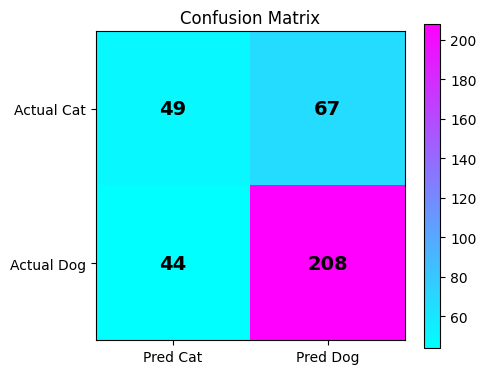

In [134]:
cm = np.array([
    [true_neg, false_pos],   # row = actual cats
    [false_neg, true_pos]    # row = actual dogs
])

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="cool")
plt.colorbar()

# Tick labels
plt.xticks([0,1], ["Pred Cat", "Pred Dog"])
plt.yticks([0,1], ["Actual Cat", "Actual Dog"])

# Annotate counts inside squares
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 ha='center', va='center',
                 fontsize=14, fontweight='bold')

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
